<a href="https://colab.research.google.com/github/kalp121212/DS203_Project/blob/main/ARWU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA for *Academic Ranking of World Universities* (ARWU)

In [1]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/kalp121212/DS203_Project/main/Datasets/Shanghai/shanghai-world-university-ranking.csv?token=ARGZ7PMUE2E5OBT6ZNWD4ETBTVVY6',
                  sep = ';')

# Overall
## Notation
Indicators and weights for ARWU : [link](https://www.shanghairanking.com/methodology/arwu/2021#:~:text=3.%20Indicators%20and,to%20other%20indicators.)

- Alumni : Alumni of an institution winning Nobel Prizes and Fields Medals
- Award  : Staff of an institution winning Nobel Prizes and Fields Medals
- HiCi   : Highly Cited Researchers
- N&S    : Papers published in Nature and Science*
- PUB    : Papers indexed in Science Citation Index-Expanded and Social Science Citation Index
- PCP    : Per capita academic performance of an institution

*For institutions specialized in humanities and social sciences such as London School of Economics, N&S is not considered, and the weight of N&S is relocated to other indicators.

For more information visit: https://www.shanghairanking.com/methodology/arwu/2021


In [3]:
def preprocess(df):
  df['World rank'] = df['World rank integer']
  df = df.drop(columns = ['Geo Shape', 'ISO2 CODE', 'ISO3 CODE', 'World rank integer','Geo Point 2D'])
  df['Total score'] = 0.1*df['Alumni']+0.2*df['Award']+0.2*df['Hi Ci']+0.2*df['N&S']+0.1*df['PCP']+0.2*df['PUB']
  df = df.dropna()
  df = df.set_index(pd.Index(list(range(len(df)))))
  df = df[['Year','University','Country','Alumni','Award','Hi Ci','N&S','PUB','PCP','Total score','World rank','National rank']]
  min_year = min(df['Year'])
  max_year = max(df['Year'])
  df_all_years = df
  df = {}
  for year in range(min_year,max_year+1):
    df[year] = df_all_years[df_all_years['Year'] == year]
    df[year] = df[year].sort_values(by = ['Total score'], ascending = False)
    df[year] = df[year].set_index(pd.Index(range(len(df[year]))))

    df[year]['World rank'] = list(range(1,len(df[year])+1))
    for i in range(1,len(df[year])):
      if df[year]['Total score'][i] == df[year]['Total score'][i-1]:
        df[year]['World rank'][i] = df[year]['World rank'][i-1]
    
  return df

In [4]:
df = preprocess(df)
min_year = min(df.keys())
max_year = max(df.keys())
print(min_year,max_year)

2005 2018


In [5]:
indexes = set(df[2018]['University'])

for j in df.keys():
    k = set(df[j]['University'])
    indexes = indexes.intersection(k)

a = list(indexes)
a.sort()
print(a)
print(len(a))

['Aarhus University', 'Aristotle University of Thessaloniki', 'Autonomous University of Barcelona', 'Autonomous University of Madrid', 'Baylor College of Medicine', 'Ben-Gurion University of the Negev', 'Boston College', 'Boston University', 'Brandeis University', 'Brigham Young University', 'Brown University', 'California Institute of Technology', 'Cardiff University', 'Carnegie Mellon University', 'Case Western Reserve University', 'Catholic University of Louvain', 'Chalmers University of Technology', 'Charles University in Prague', 'City University of Hong Kong', 'City University of New York City College', 'Claude Bernard University Lyon 1', 'Colorado State University', 'Columbia University', 'Complutense University of Madrid', 'Cornell University', 'Dalhousie University', 'Dartmouth College', 'Delft University of Technology', 'Drexel University', 'Duke University', 'Ecole Normale Superieure - Paris', 'Ecole Polytechnique', 'Eindhoven University of Technology', 'Emory University', '

In [6]:
data = pd.DataFrame()
for i in df.keys():
    curr = df[i][df[i]['University'].isin(indexes)].assign(year=i)
    data = pd.concat([data,curr], axis=0)

In [7]:
display(data)

Year  ...  year
0    2005  ...  2005
1    2005  ...  2005
2    2005  ...  2005
4    2005  ...  2005
5    2005  ...  2005
..    ...  ...   ...
467  2018  ...  2018
472  2018  ...  2018
474  2018  ...  2018
487  2018  ...  2018
497  2018  ...  2018

[4433 rows x 13 columns]

# Statistics for overall

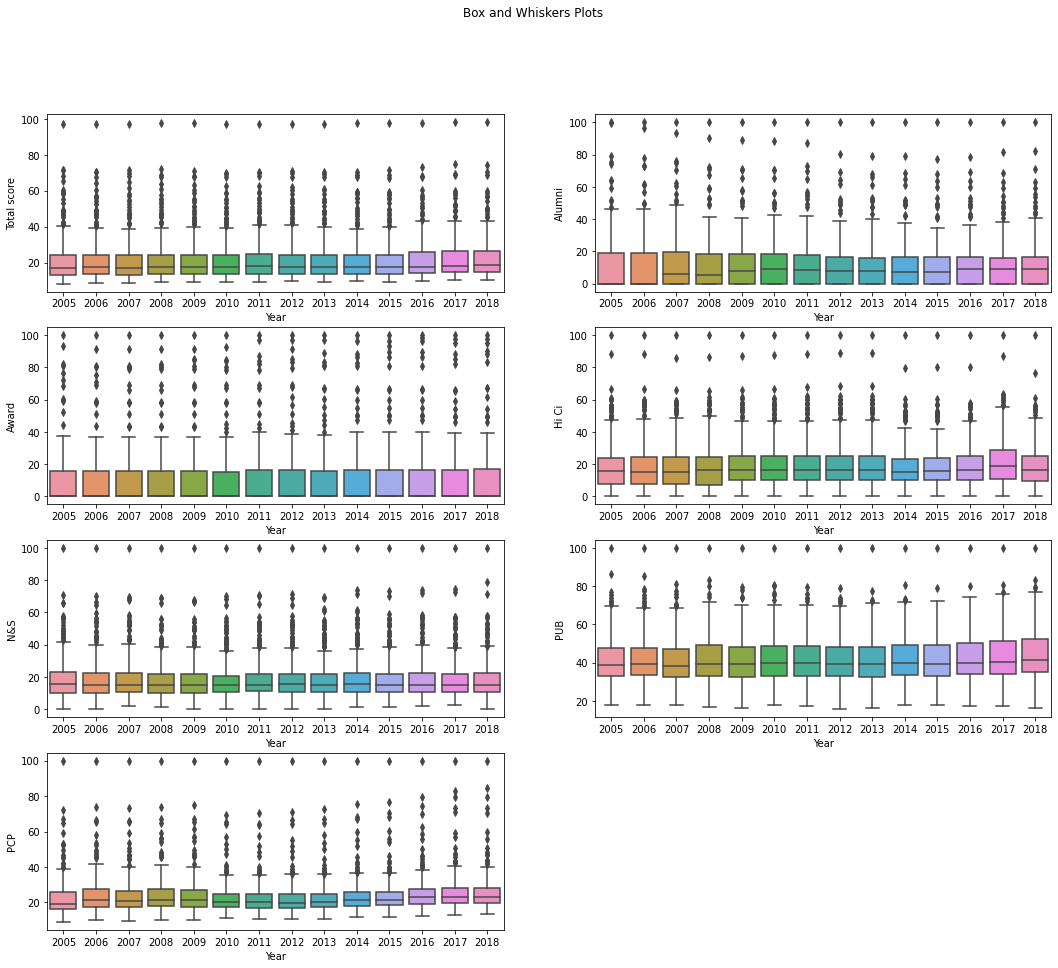

In [8]:
plt.rcParams['figure.figsize'] = [18,15]

cols = ['Total score','Alumni','Award','Hi Ci','N&S','PUB','PCP']
plt.figure()
plt.suptitle("Box and Whiskers Plots")
for i in range(len(cols)):
    plt.subplot(4,2,i+1)
    sns.boxplot(x="Year",y=cols[i],data=data)
    plt.xlabel("Year")
    plt.ylabel(cols[i])
plt.show()

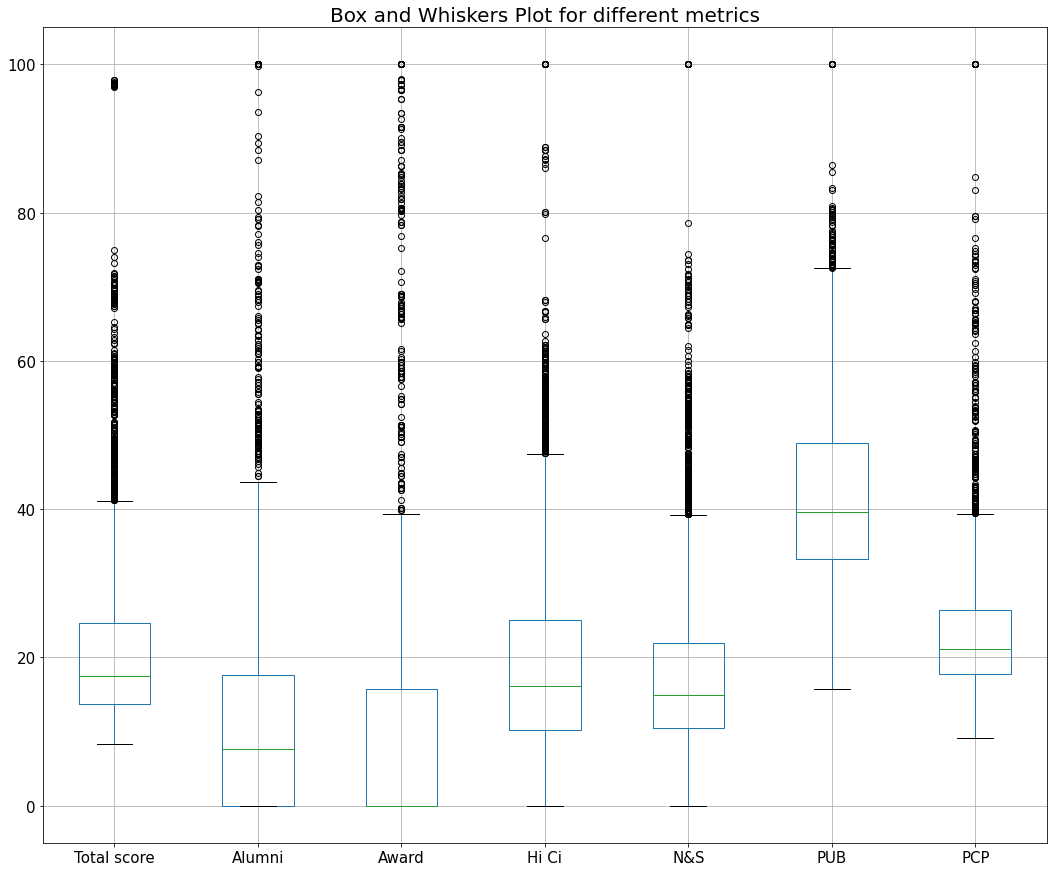

In [9]:
data.boxplot(column = cols, fontsize = 15)
plt.title('Box and Whiskers Plot for different metrics',fontdict={'fontsize':20})
pass

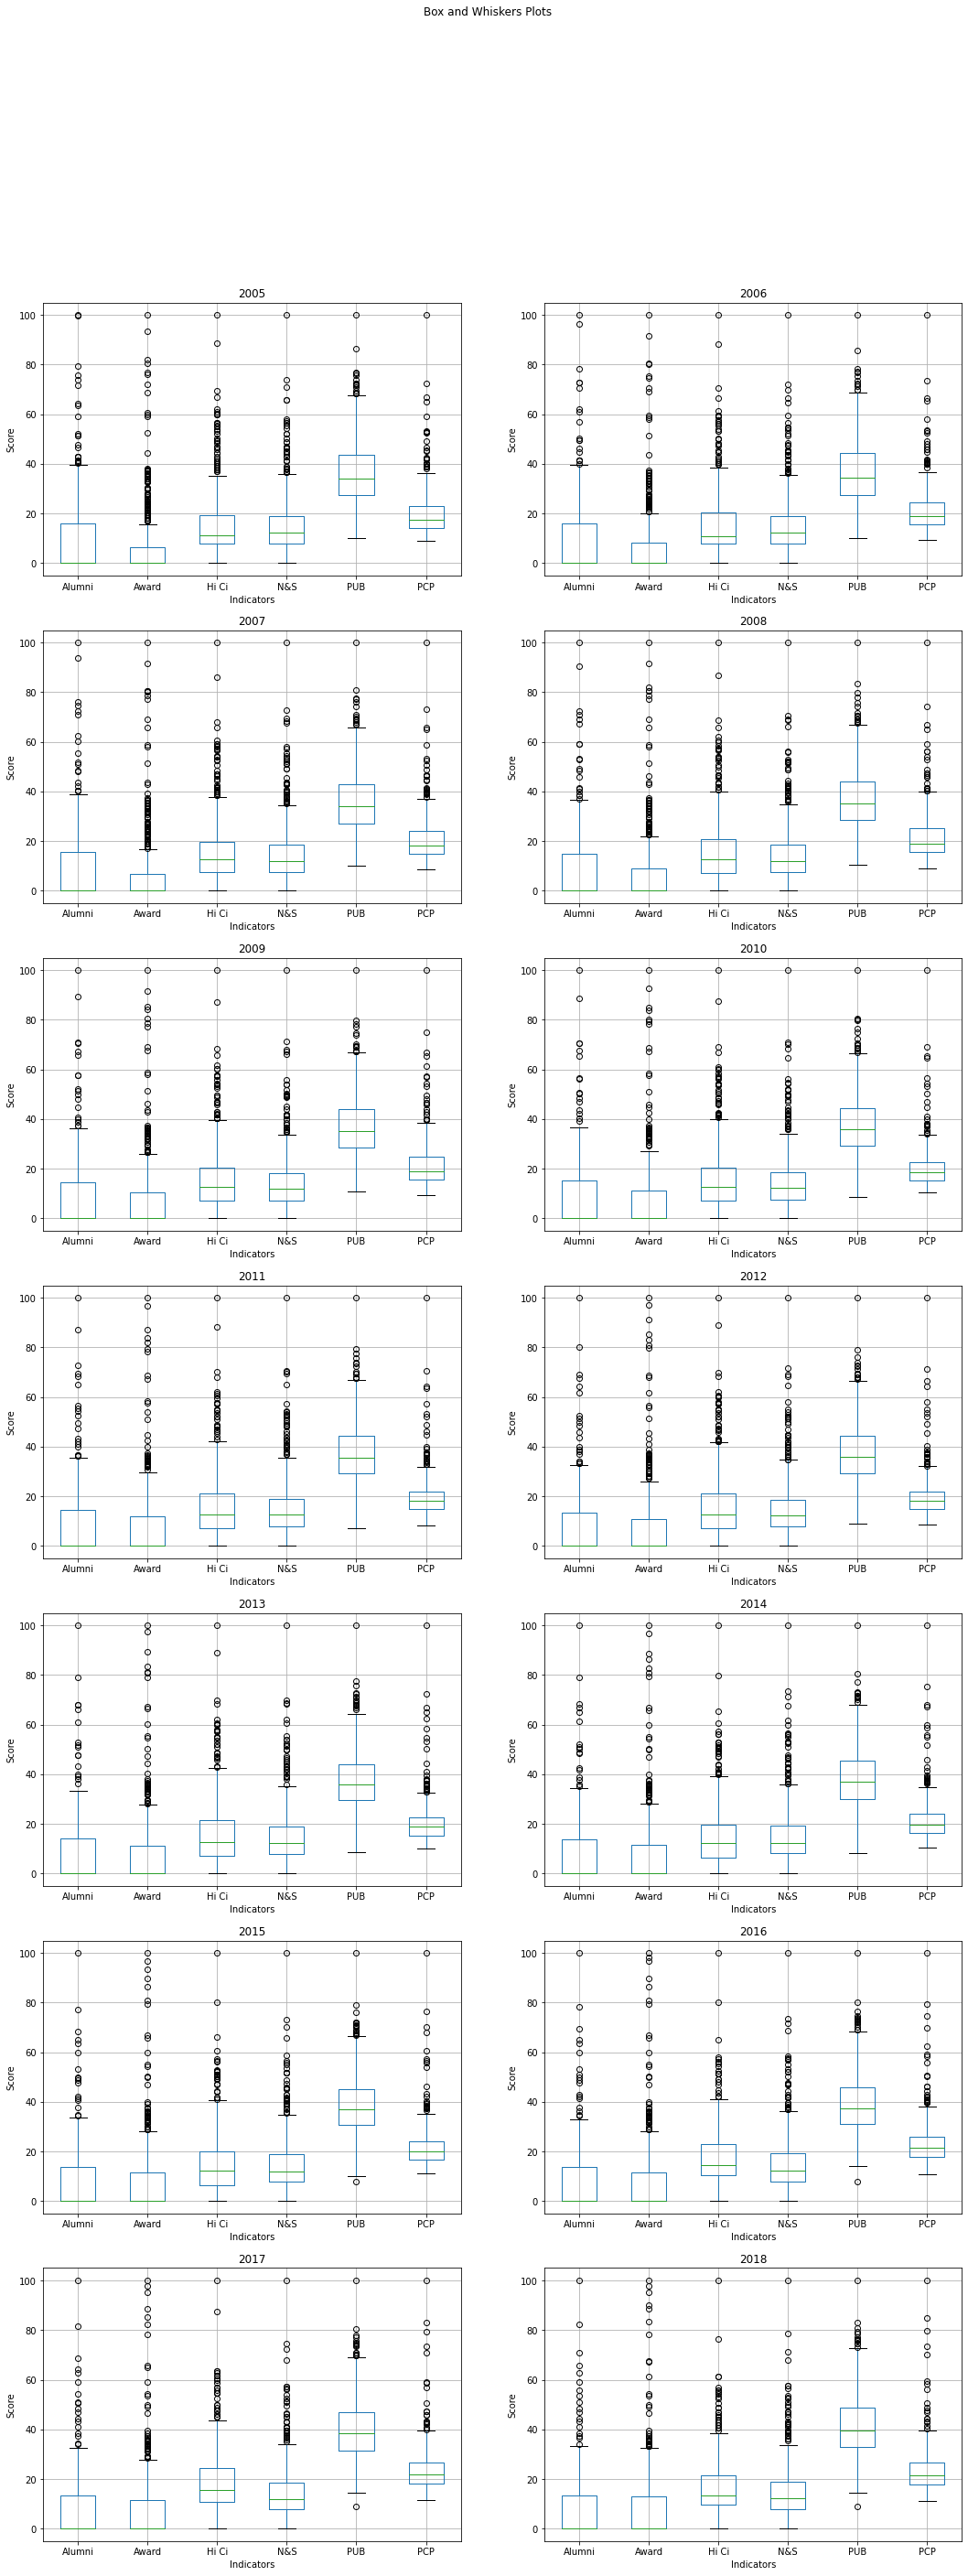

In [10]:
plt.rcParams['figure.figsize'] = [18,45]

cols = ['Alumni','Award','Hi Ci','N&S','PUB','PCP']
plt.figure()
plt.suptitle("Box and Whiskers Plots")
for i in range(min_year,max_year+1):
    plt.subplot(7,2,i+1-min_year)
    df[i][cols].boxplot(column = cols)
    plt.xlabel("Indicators")
    plt.ylabel("Score")
    plt.title(str(i))
plt.show()

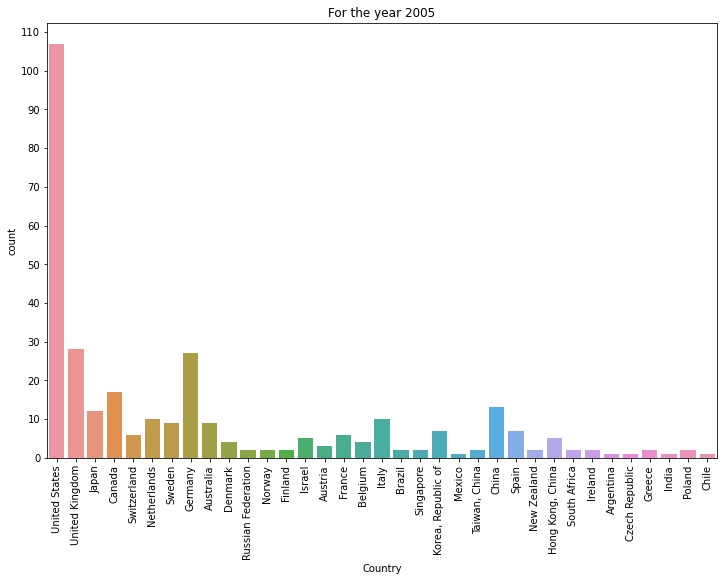

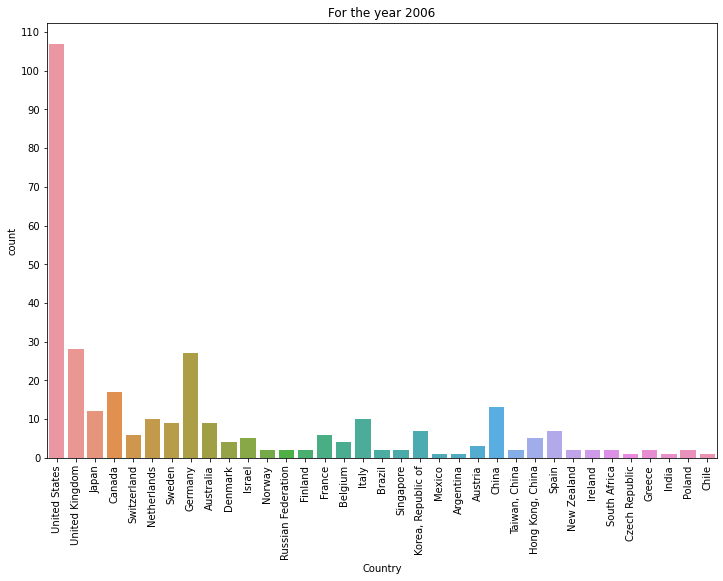

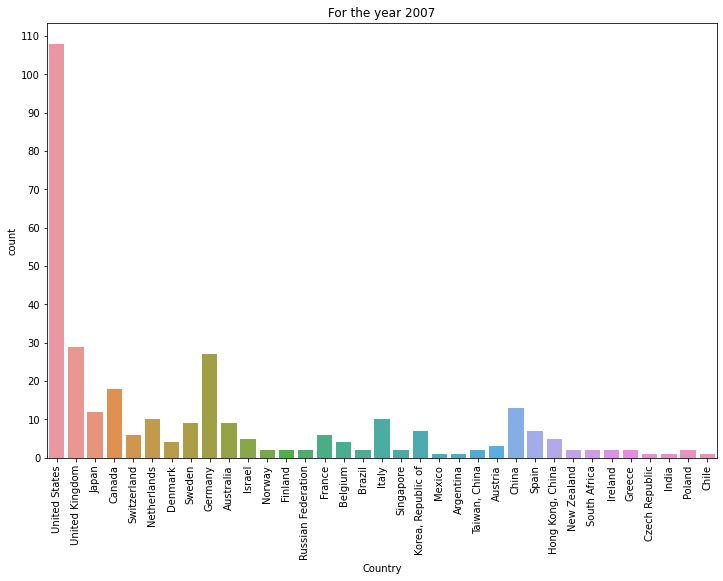

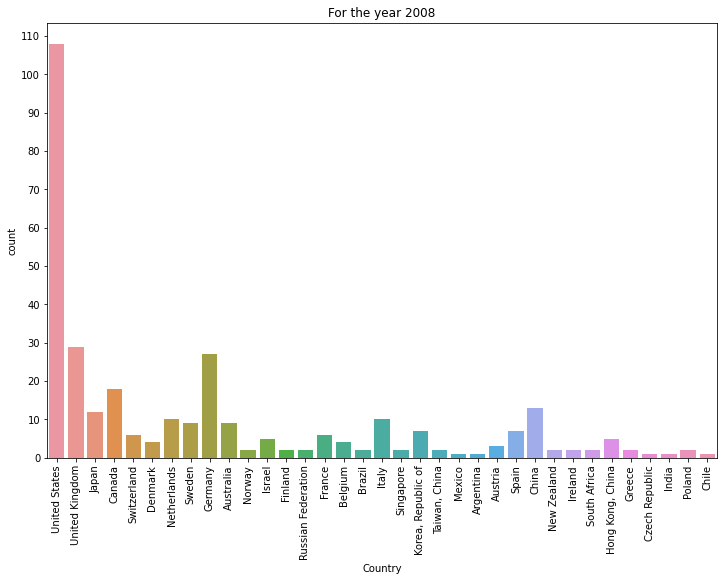

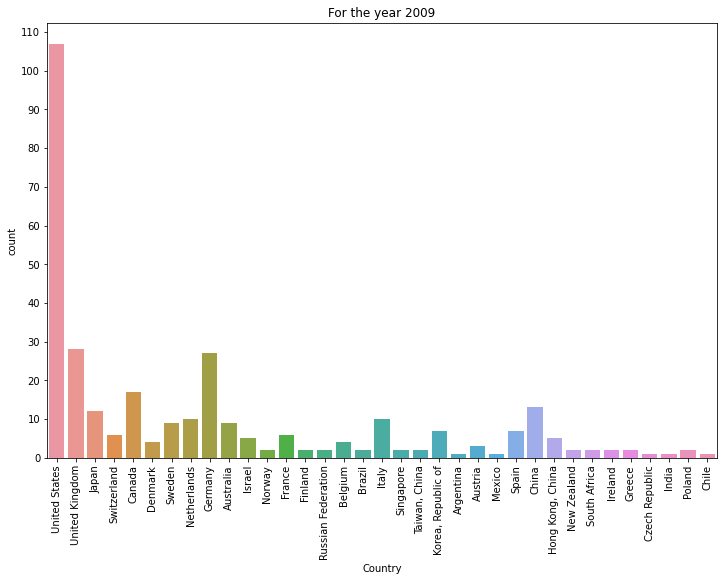

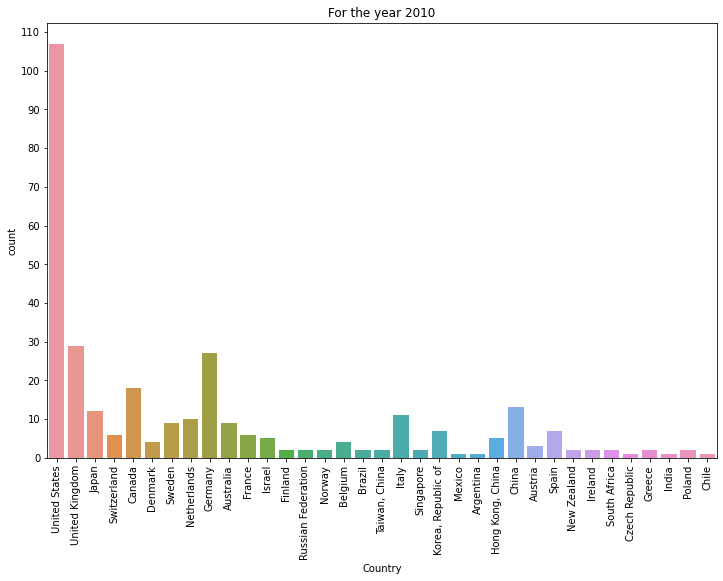

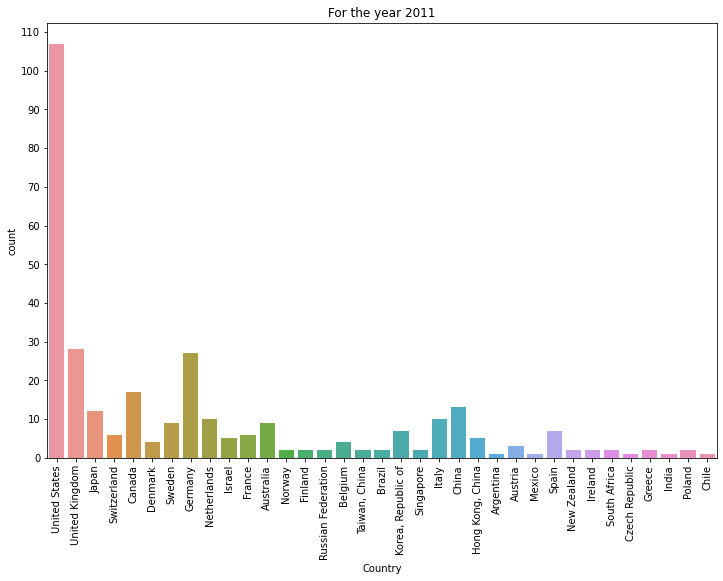

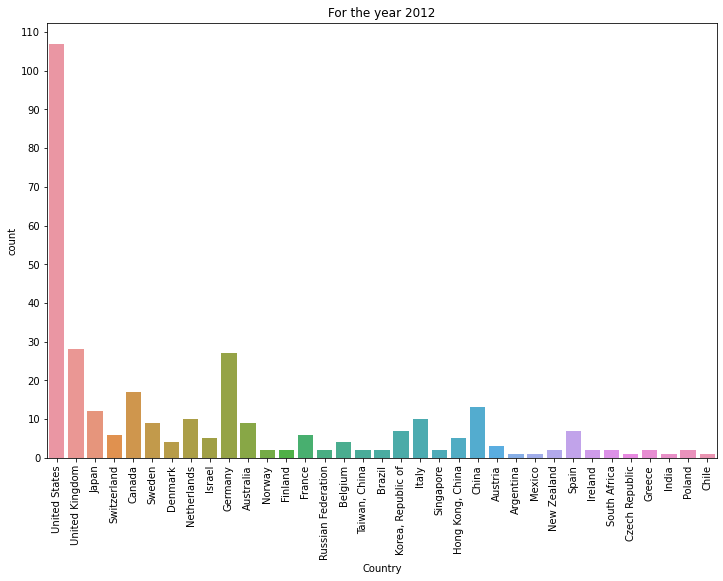

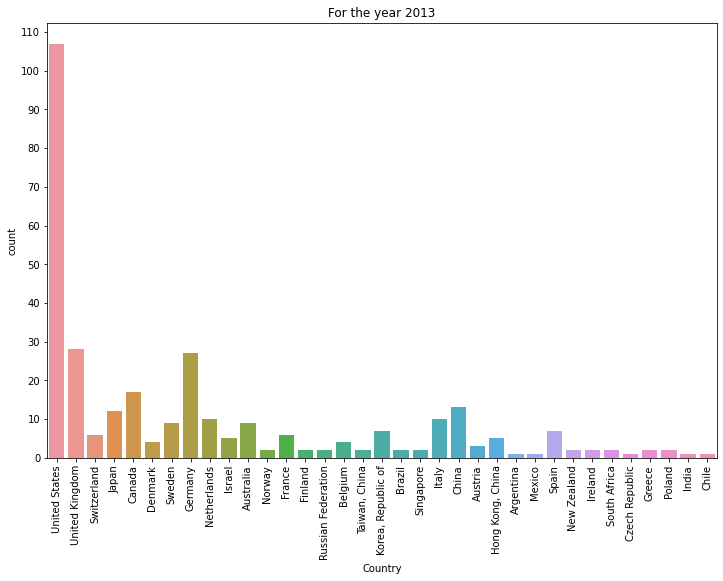

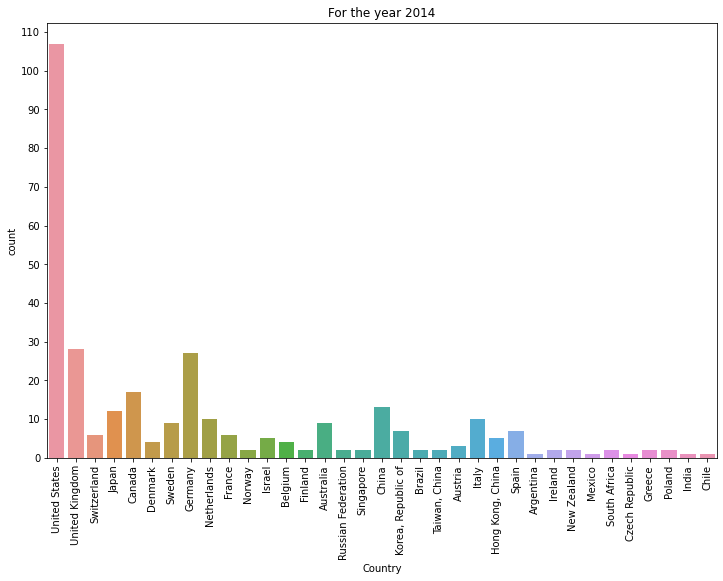

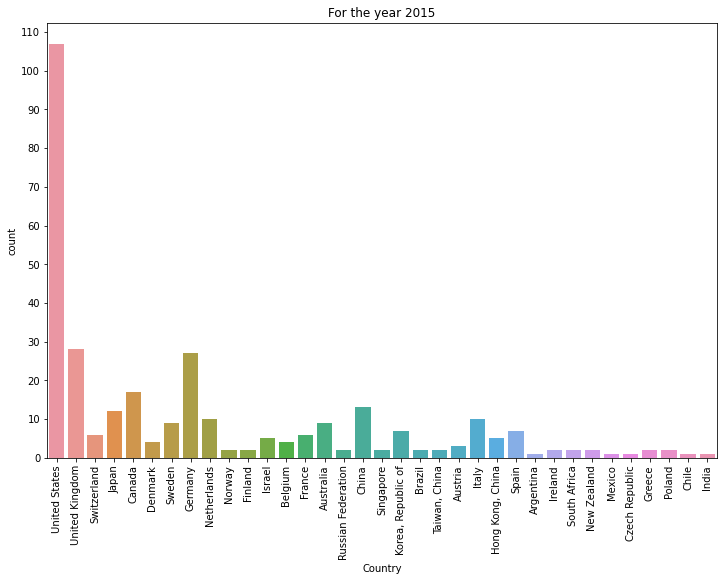

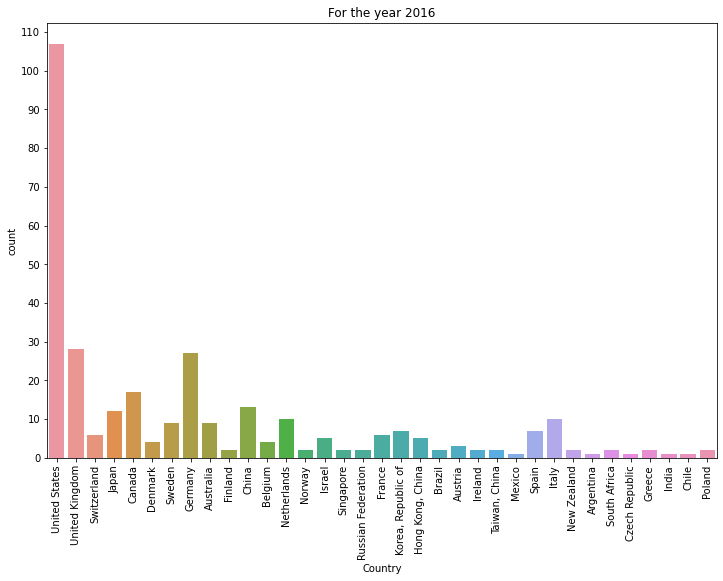

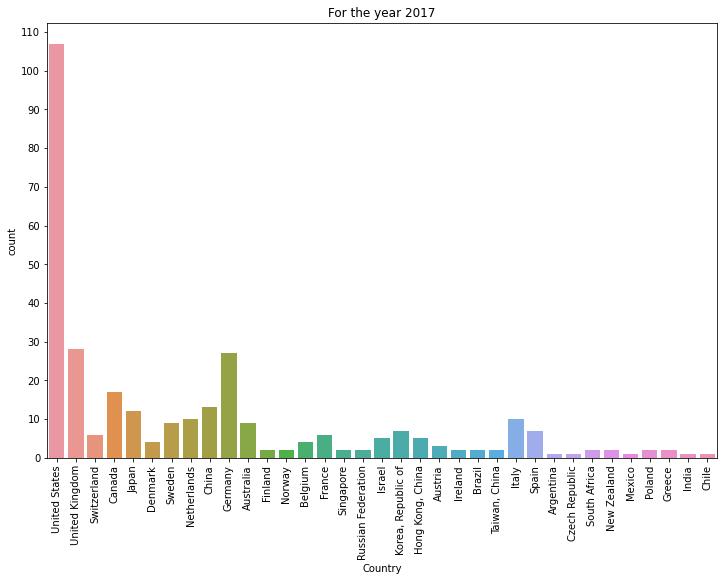

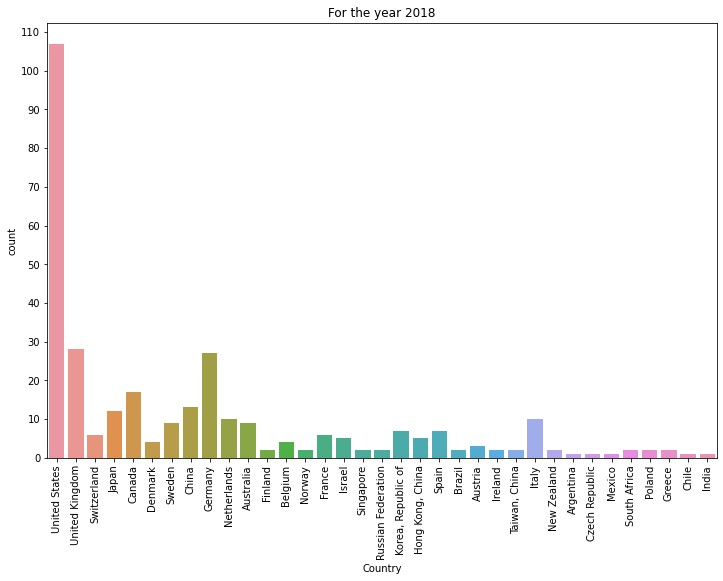

In [11]:
plt.rcParams['figure.figsize'] = [12,8]
for i,j in data.groupby('Year'):
    val = j
    plt.title(f"For the year {i}")
    plt.xticks(rotation='vertical')
    plt.yticks(range(0,120,10))
    plt.xlabel("Country")
    plt.ylabel("No of colleges")
    sns.countplot(val['Country'])
    plt.show()

# Mean plots for batches of 10

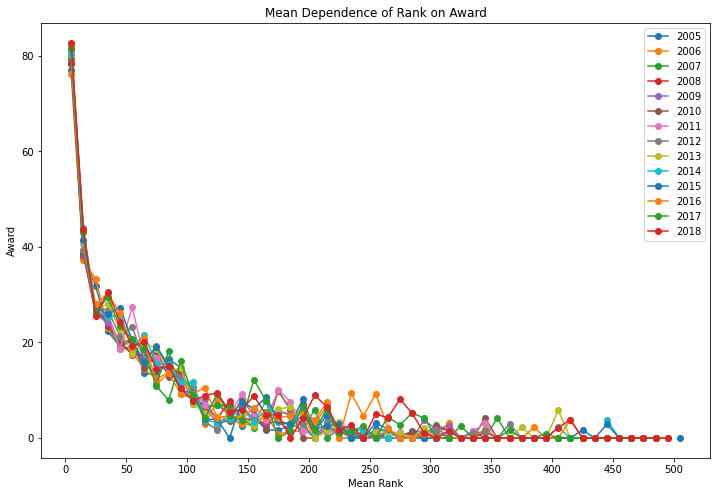

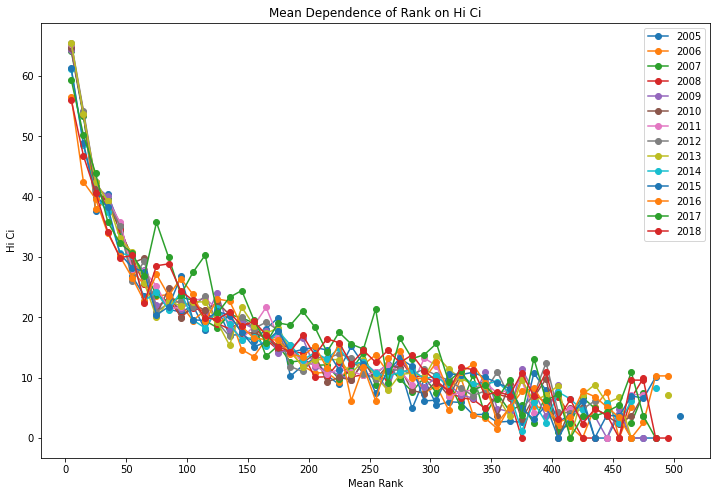

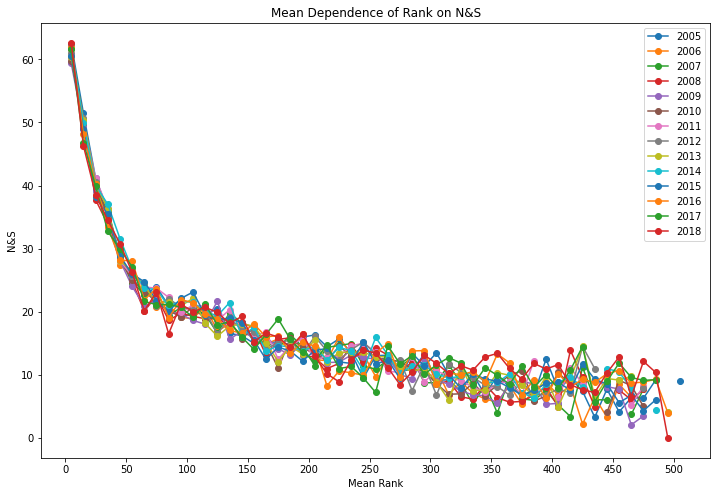

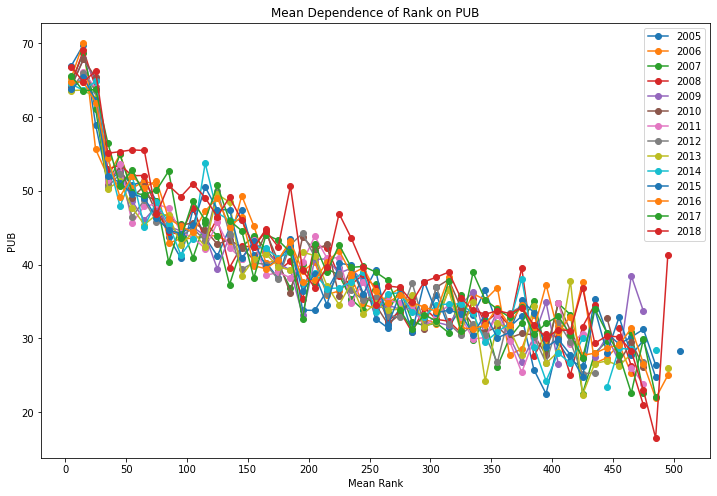

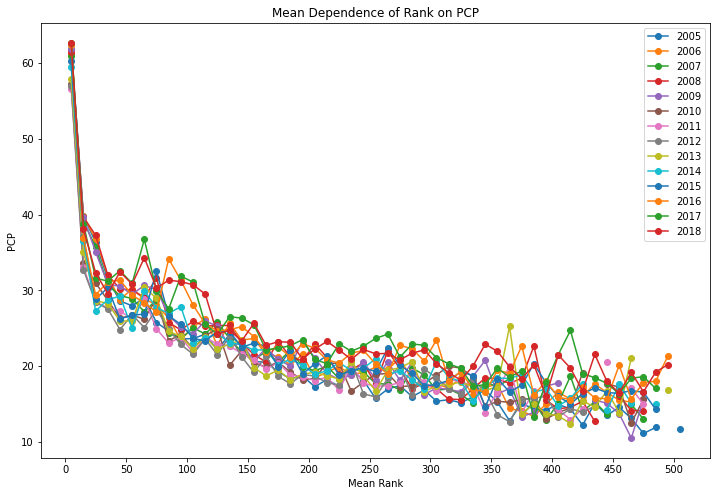

In [12]:
for x in cols[1:]:
    for i,j in data.groupby('Year'):
        ranks = list(range(0,501,10))
        y_data = []
        x_data = []
        j["rank"] = j["World rank"]
        for rank in ranks:
            y_data += [np.mean(np.array(j.query(f"rank>={rank} and rank<={rank+10}")[x]))]
            x_data += [rank+5]
        plt.plot(x_data,y_data,'o-',label=f"{i}")
    plt.title(f"Mean Dependence of Rank on {x}")
    plt.ylabel(f"{x}")
    plt.xlabel("Mean Rank")
    plt.xticks(range(0,501,50))
    plt.legend()
    plt.show()

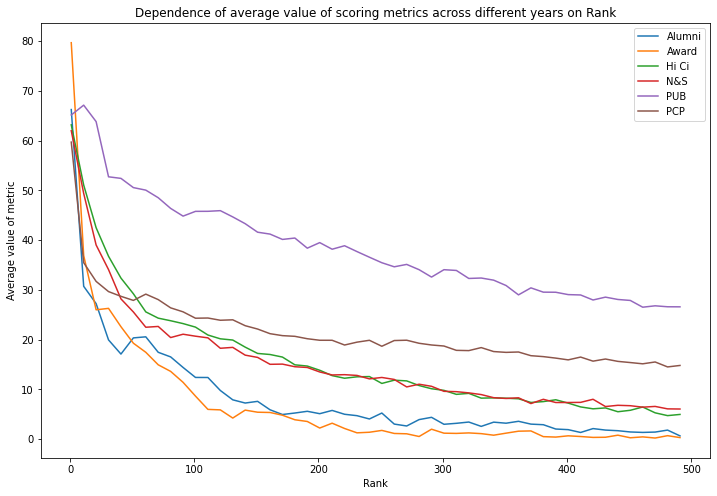

In [13]:
for metric in cols:
  scores = []
  ranks = list(range(1,500,10))
  diff = 10
  for rank in ranks:
    score = 0
    num_scores = 0
    for year in range(min_year,max_year+1):
      score += sum(df[year][np.logical_and(rank <= np.array(df[year]['World rank']), np.array(df[year]['World rank']) <rank+ diff)][metric])
      num_scores += len(df[year][np.logical_and(rank <= np.array(df[year]['World rank']), np.array(df[year]['World rank']) <rank+ diff)])
    if num_scores != 0:
      avg_score = score/num_scores
    else:
      avg_score = 0
    scores += [avg_score]
  plt.plot(ranks, scores, label = metric)

plt.xlabel('Rank')
plt.ylabel('Average value of metric')
plt.title('Dependence of average value of scoring metrics across different years on Rank')
plt.legend()
pass

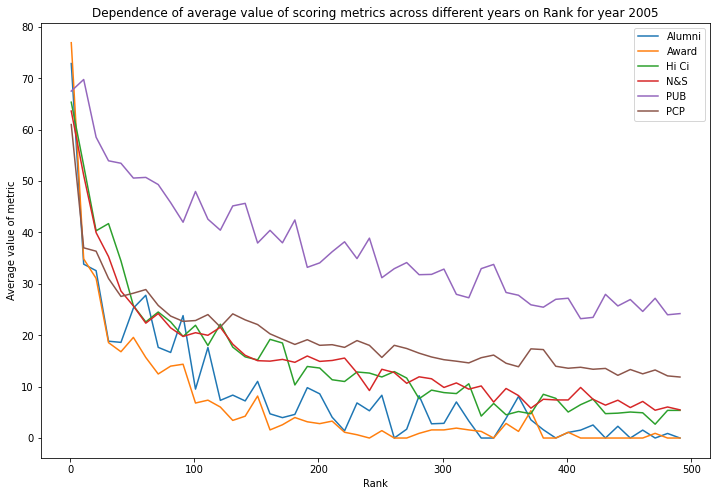

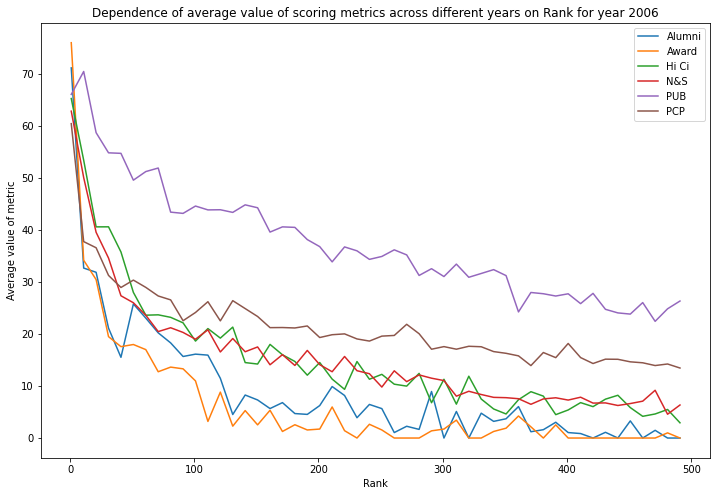

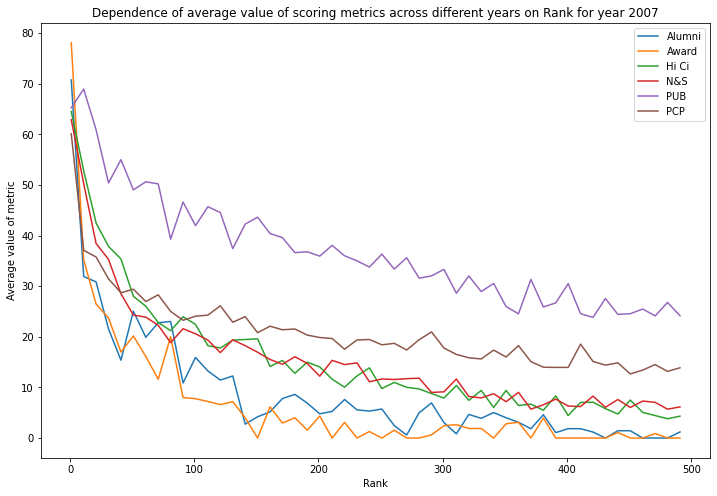

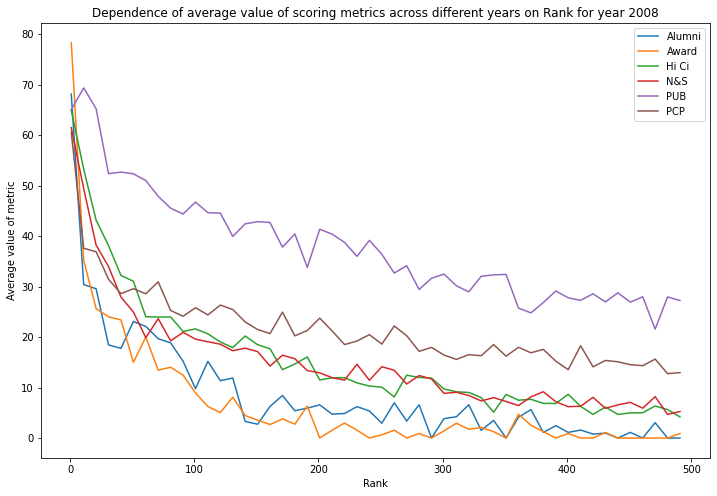

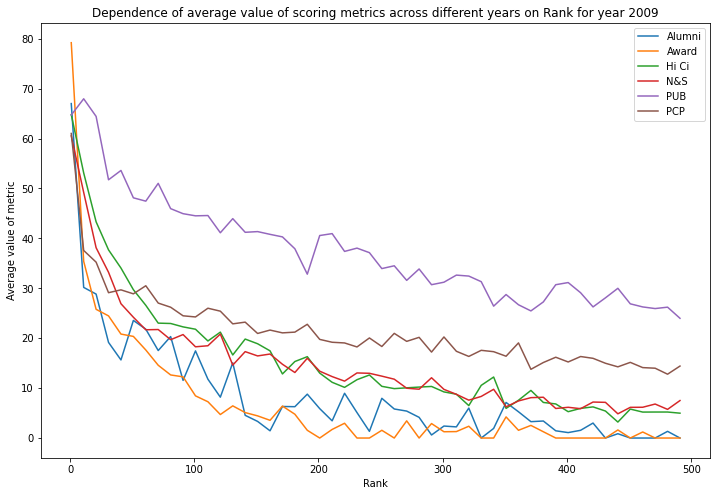

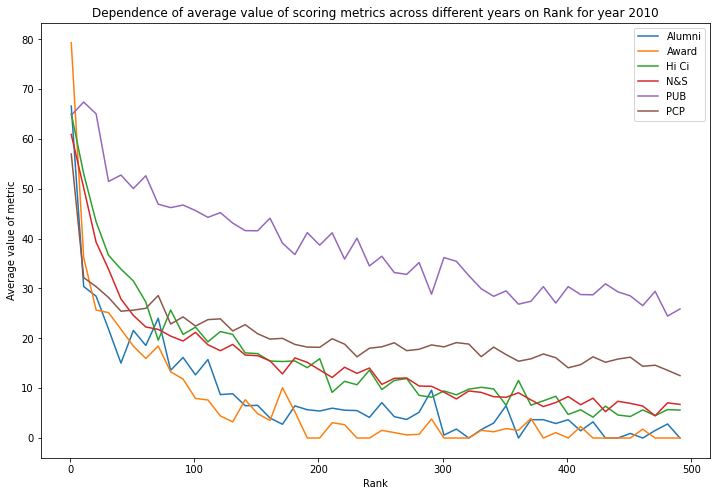

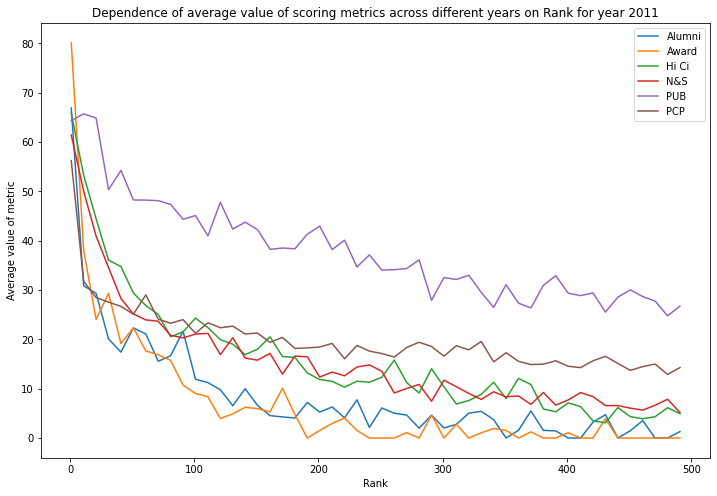

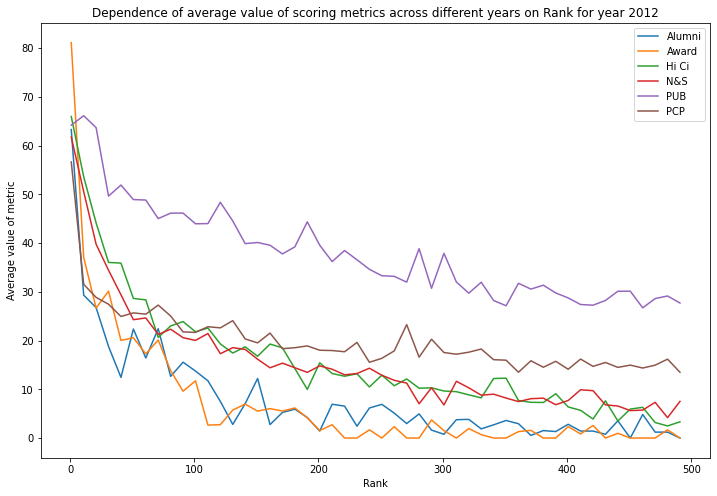

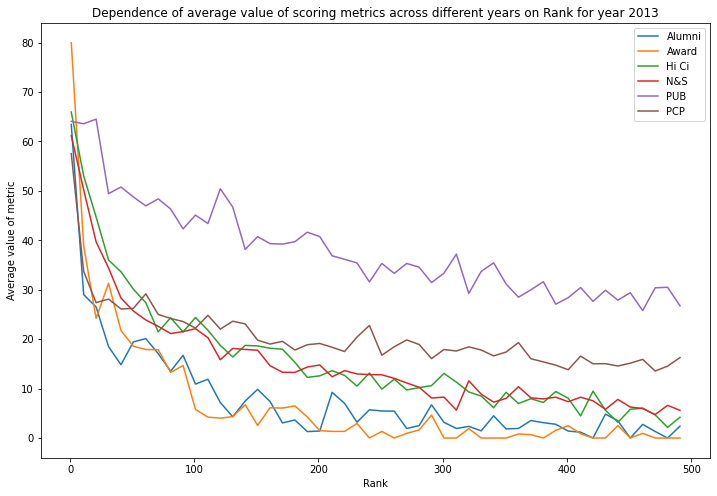

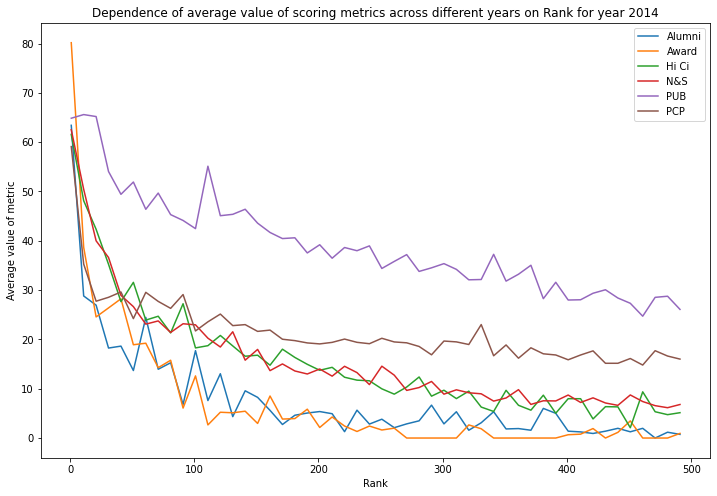

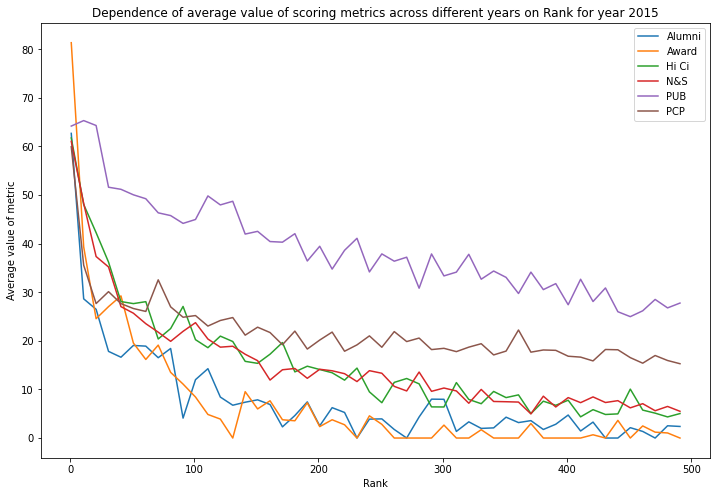

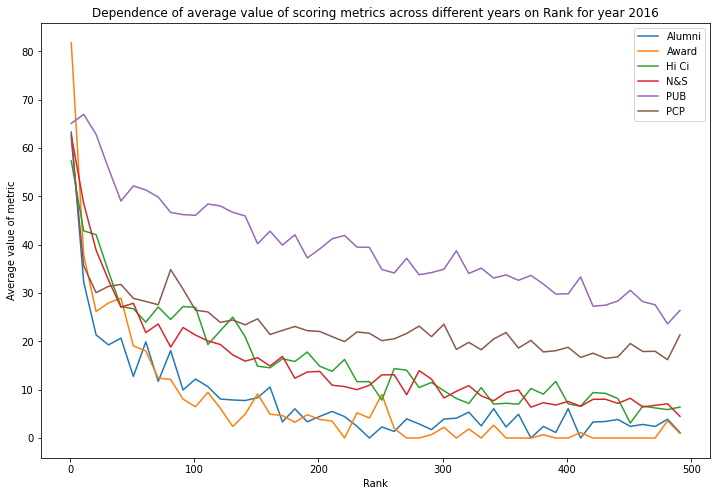

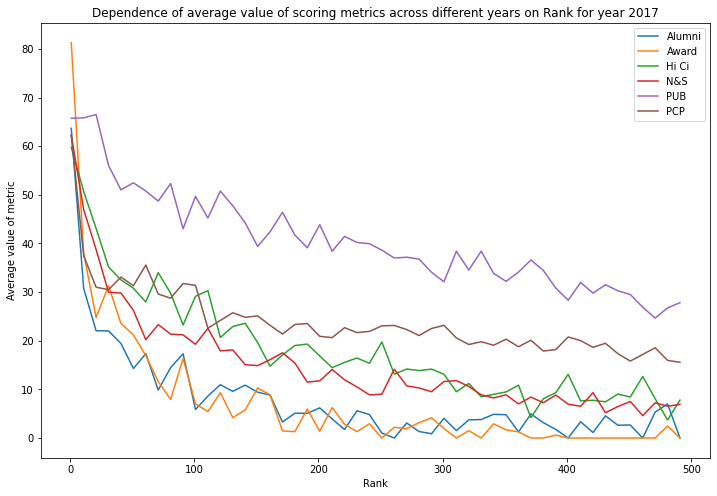

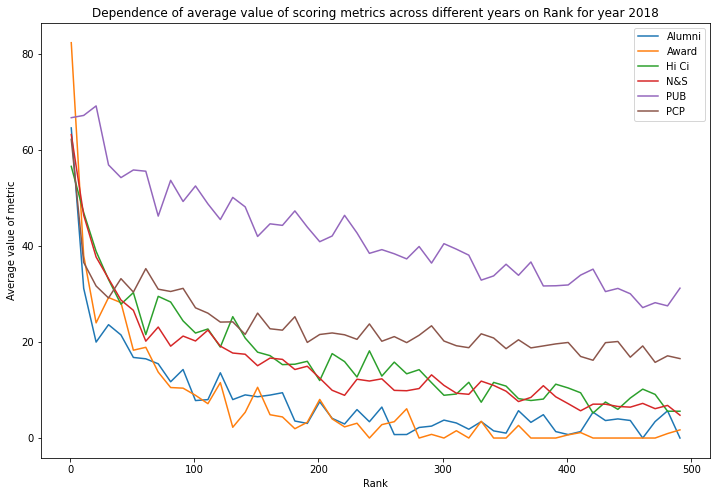

In [14]:
for year in range(min_year,max_year+1):
  for metric in cols:
    scores = []
    ranks = list(range(1,500,10))
    diff = 10
    for rank in ranks:
      score = sum(df[year][np.logical_and(rank <= np.array(df[year]['World rank']), np.array(df[year]['World rank']) <rank+ diff)][metric])
      num_scores = len(df[year][np.logical_and(rank <= np.array(df[year]['World rank']), np.array(df[year]['World rank']) <rank+ diff)])
      if num_scores != 0:
        avg_score = score/num_scores
      else:
        avg_score = 0
      scores += [avg_score]
    plt.plot(ranks, scores, label = metric)

  plt.xlabel('Rank')
  plt.ylabel('Average value of metric')
  plt.title(f'Dependence of average value of scoring metrics across different years on Rank for year {year}')
  plt.legend()
  plt.show()
pass

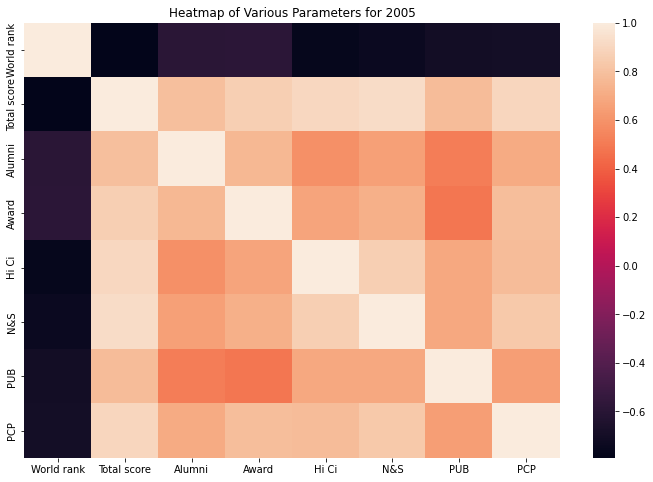

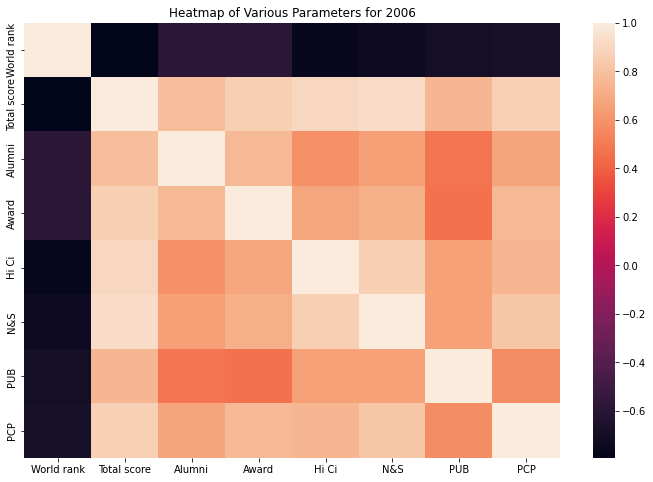

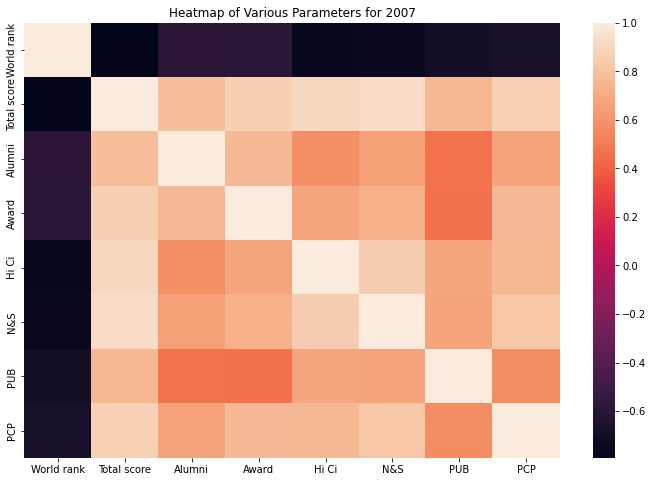

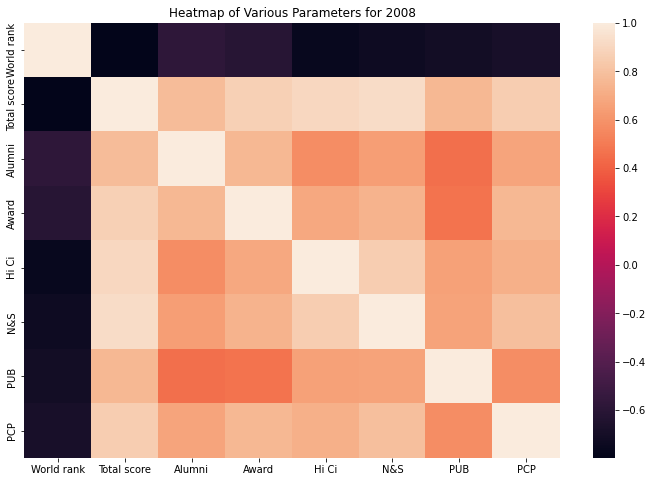

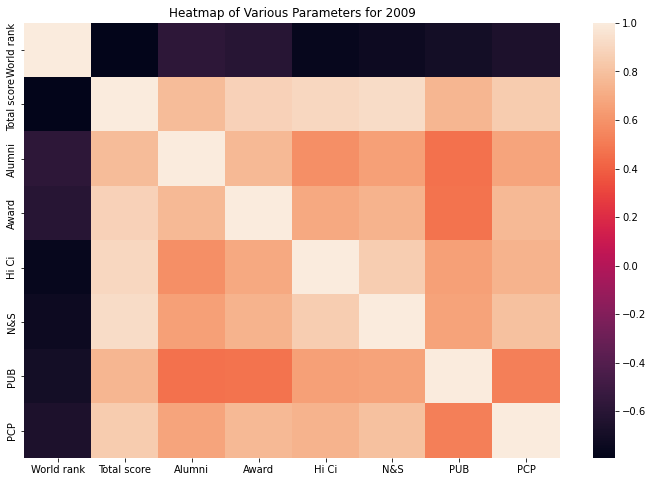

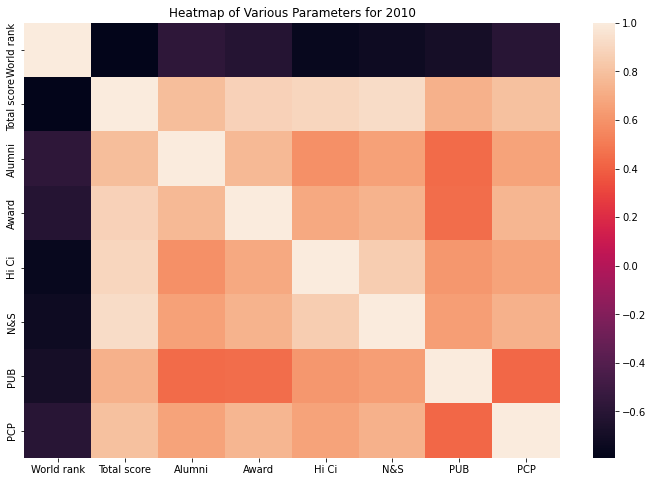

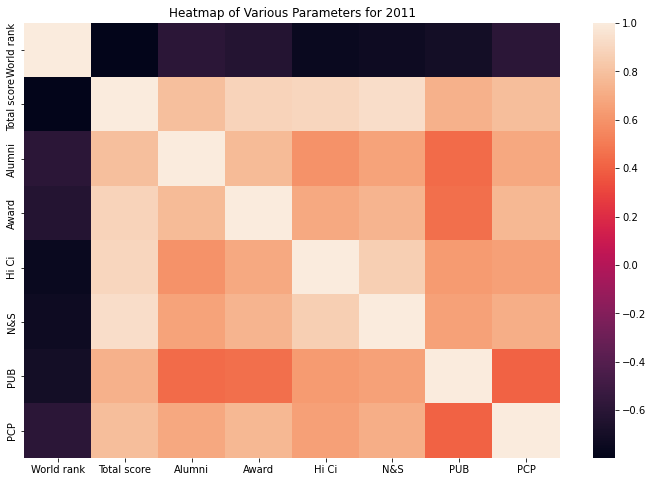

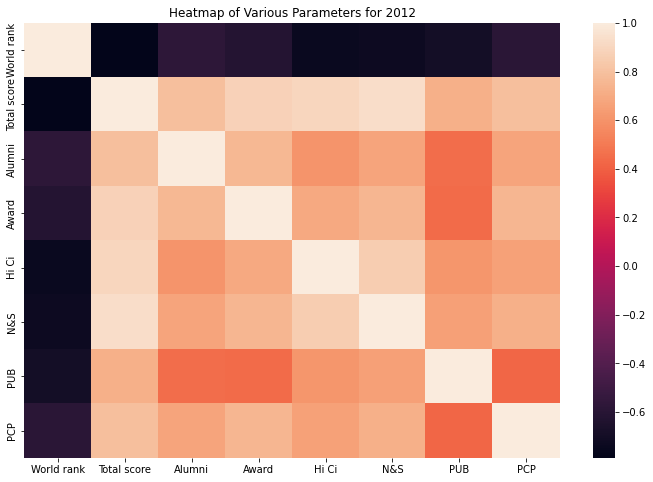

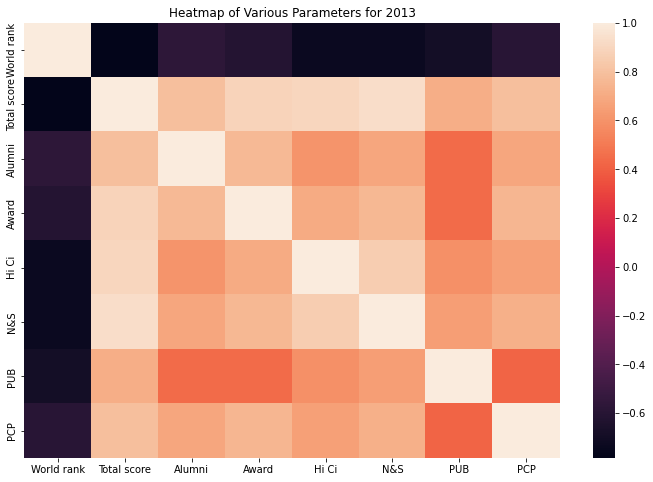

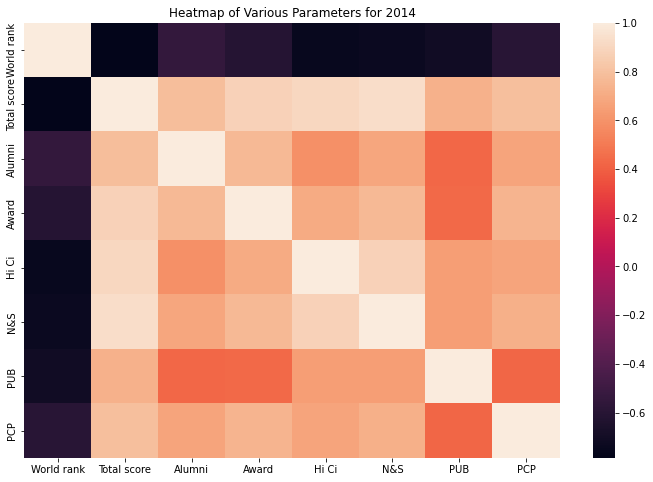

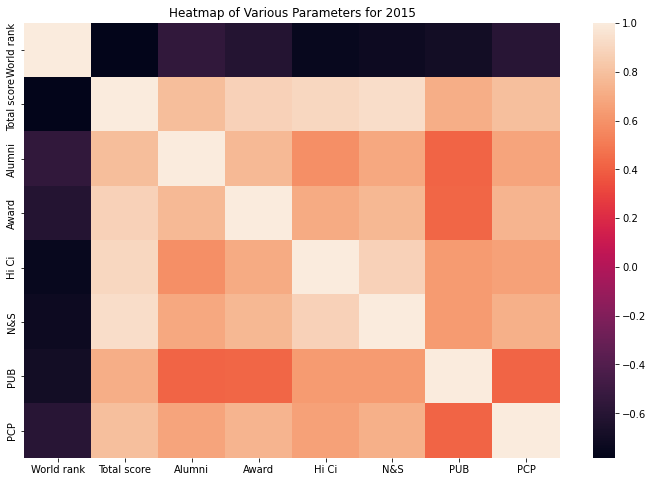

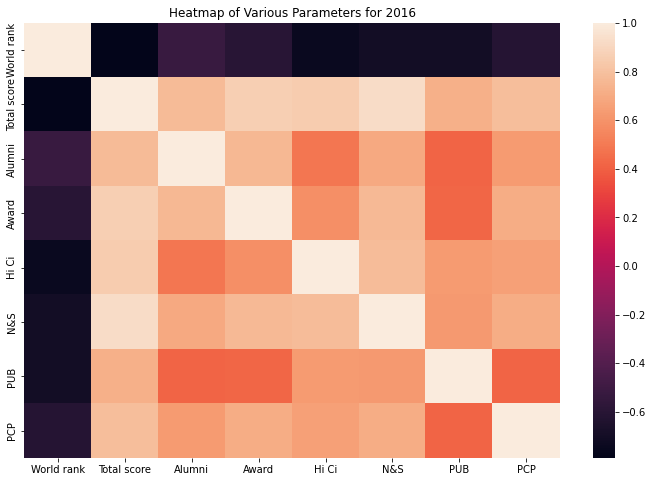

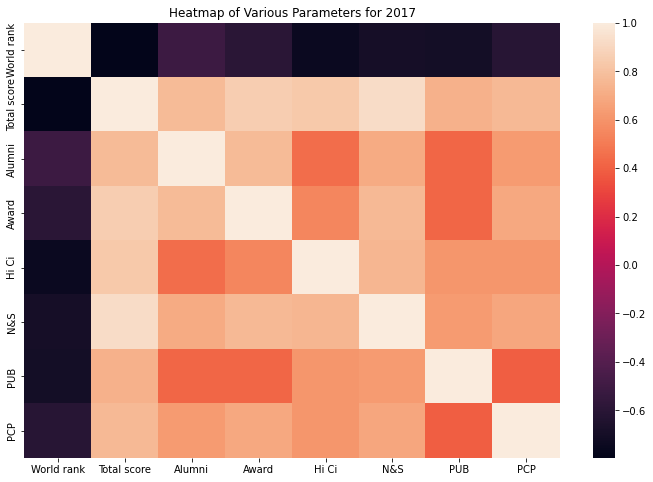

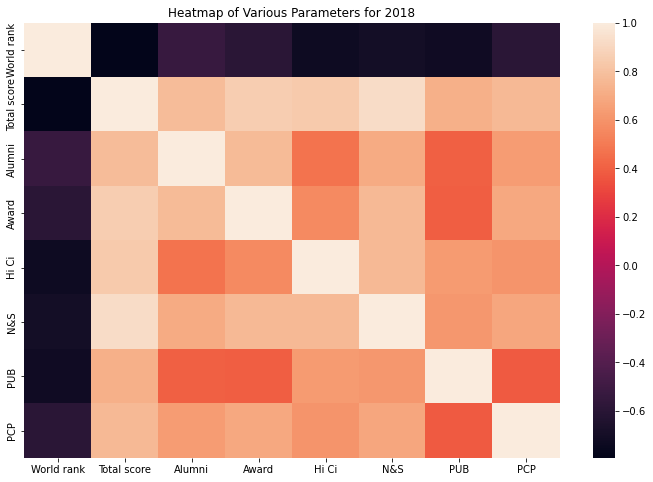

In [15]:
plt.rcParams['figure.figsize'] = [12,8]
k=['World rank','Total score','Alumni','Award','Hi Ci','N&S','PUB','PCP']
for i,j in data.groupby('Year'):
    plt.title(f"Heatmap of Various Parameters for {i}")
    sns.heatmap(j[k].corr())
    plt.show()

In [16]:
!pip install pycountry_convert

In [17]:
import pycountry_convert as pc

In [18]:
def country_to_continent(country):
  if ',' in country:
    i = country.index(',')
    country = country[:i]
  if country == 'Korea':
    return 'Asia'
  country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
  continent_name = pc.country_alpha2_to_continent_code(country_code)
  continents = {
      'NA': 'North America',
      'SA': 'South America', 
      'AS': 'Asia',
      'OC': 'Australia',
      'AF': 'Africa',
      'EU': 'Europe'
  }
  return continents[continent_name]

In [19]:
for year in  range(min_year,max_year+1):
  df[year]['Continent'] = df[year]['Country'].apply(country_to_continent)

In [20]:
continents = [
      'North America',
      'South America', 
      'Europe',
      'Africa',
      'Asia',
      'Australia',
]

continent_info = {}
for year in range(min_year,max_year+1):
  scores = {}
  num_univs = {}
  for continent in continents:
    scores[continent] = 0
    num_univs[continent] = 0
  for i in range(len(df[year])):
    scores[df[year]['Continent'][i]] += df[year]['Total score'][i]
    num_univs[df[year]['Continent'][i]] += 1
  continent_info[year] = {'scores':scores, 'num_univs':num_univs}

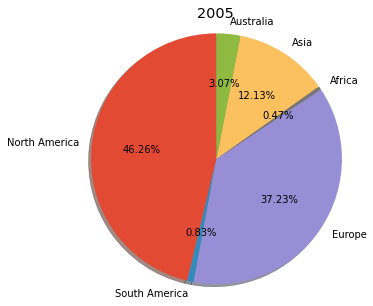

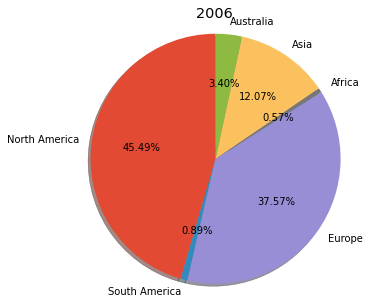

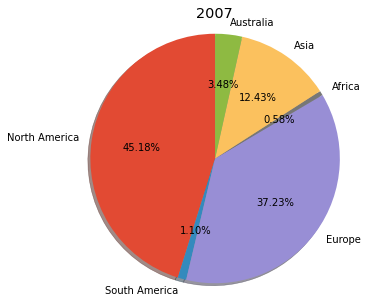

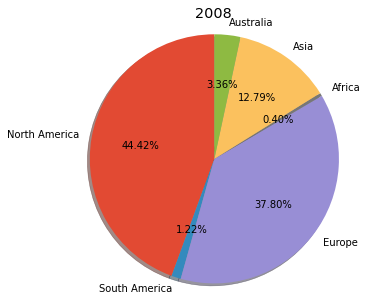

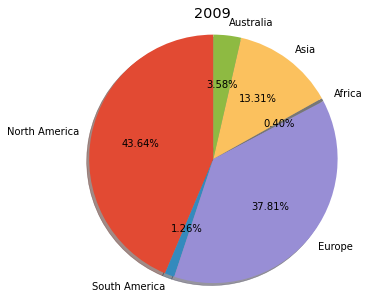

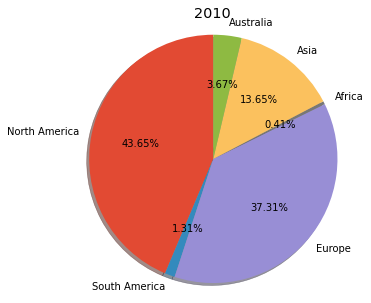

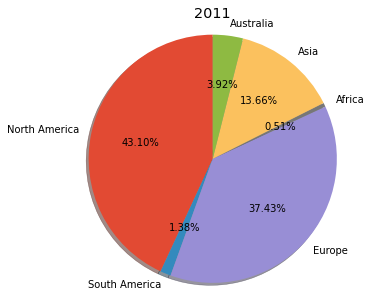

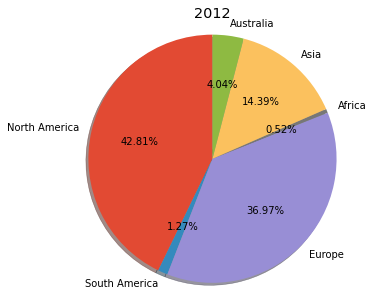

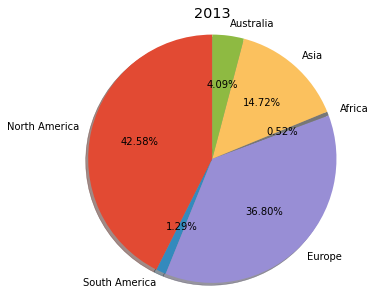

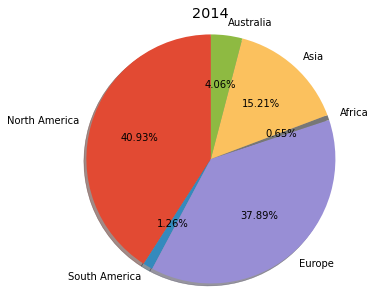

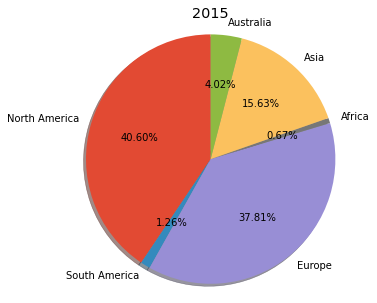

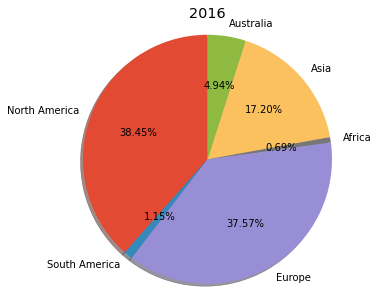

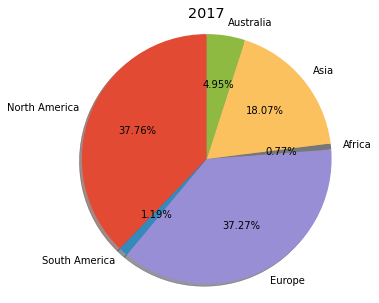

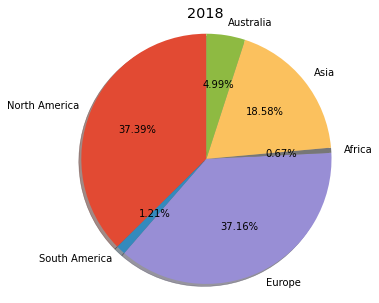

In [21]:
# Total score of univs in a continent
plt.rcParams['figure.figsize'] = 5,5
plt.style.use('ggplot')
for year in range(min_year,max_year+1):
  labels = continents
  sizes = [continent_info[year]['scores'][continent] for continent in continents]

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title(str(year))
plt.show()

### **The above pi charts show the distrbution of cumulative total scores of all universities in a continent**
- The share of **North American** universities have **decreased significantly** from 46.3 % in min_year to 37.4% in max_year.
- The share of **European** Universities have **remained** pretty much **constant** through the years. 
- The share of **South American** universities **increased slightly** from 0.8% to around 1.2% and has remained pretty much **constant in later years**.
- The **Asian and Australian universities** have steadily grown in shares. Asia went from 12.1% to 18.6% while Australia went from 3.1% to 5%.
- Even **Africa** has shown **slight improvements** going from 0.47% to 0.67% in peaking at around 0.77%.
- Europe might overtake N America
> **The trends show that the education quality is slowly shifting from the west to the east**.

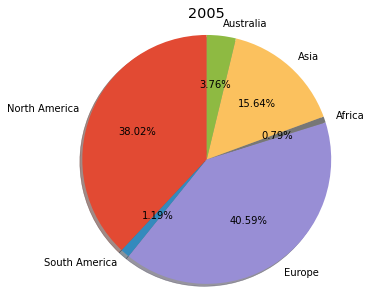

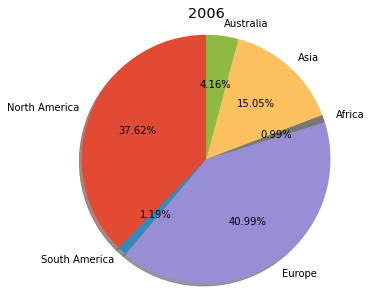

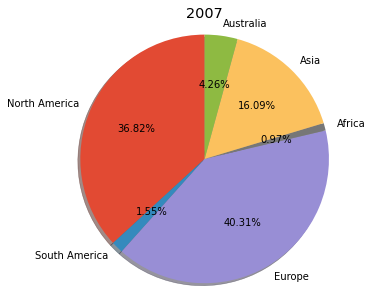

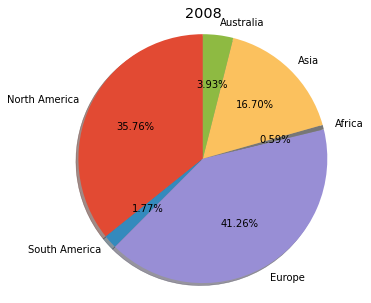

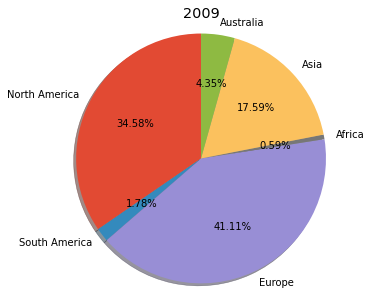

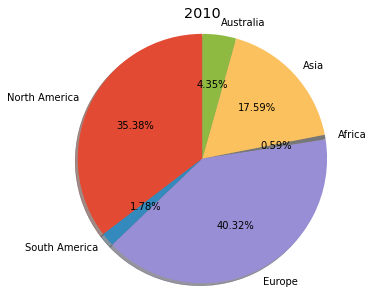

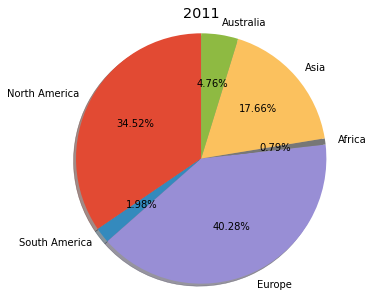

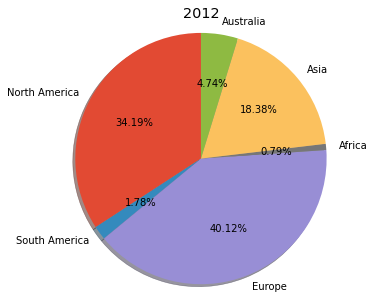

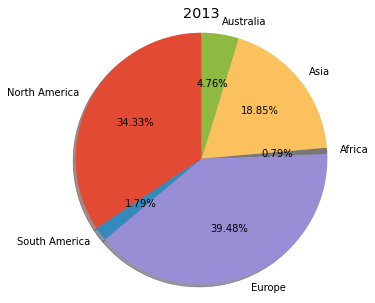

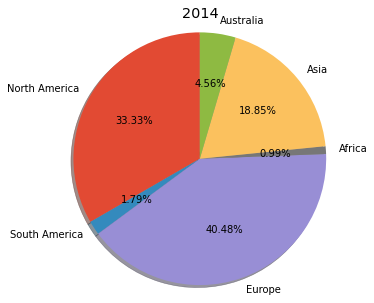

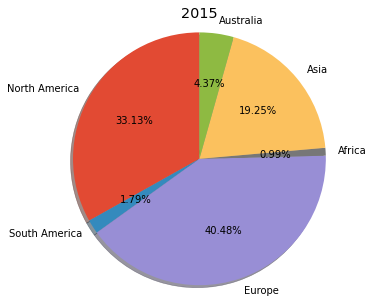

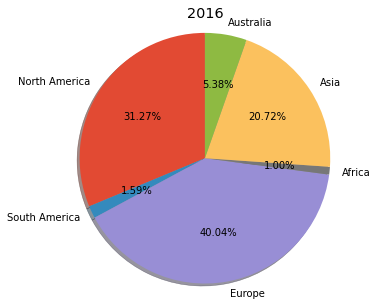

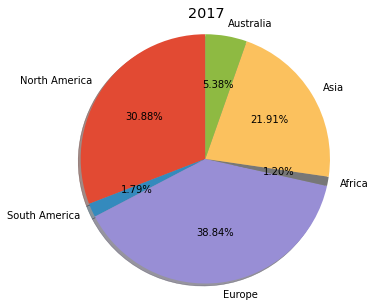

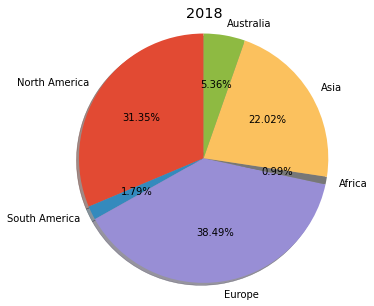

In [22]:
# Number of universities vs continent
plt.rcParams['figure.figsize'] = 5,5
for year in range(min_year,max_year+1):
  labels = continents
  sizes = [continent_info[year]['num_univs'][continent] for continent in continents]

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title(str(year))
plt.show()

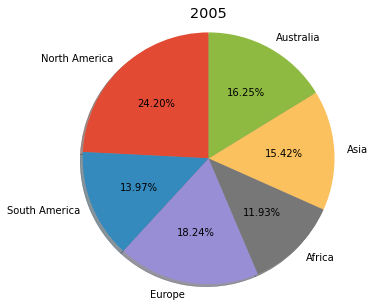

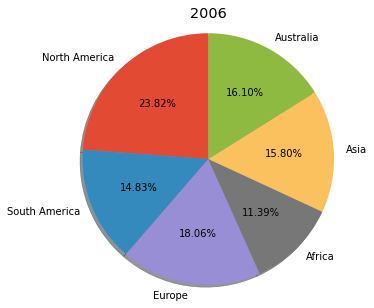

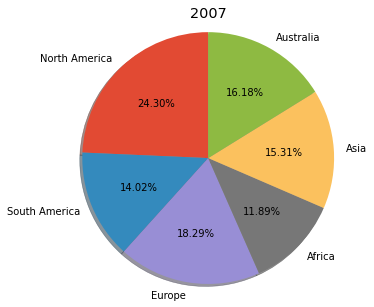

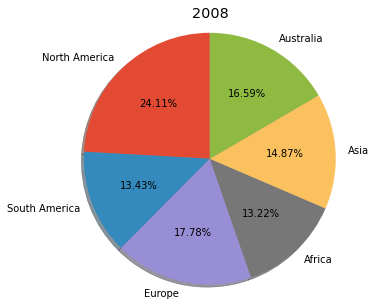

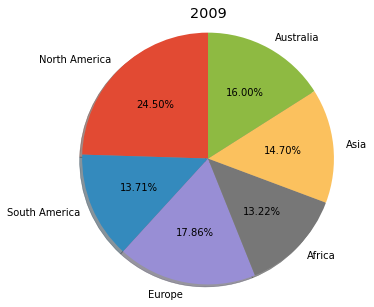

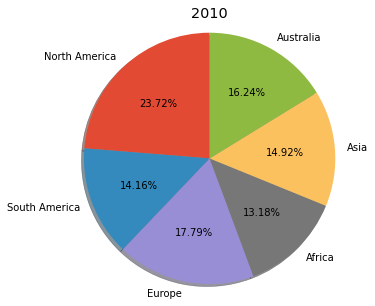

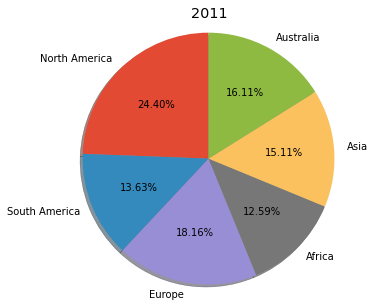

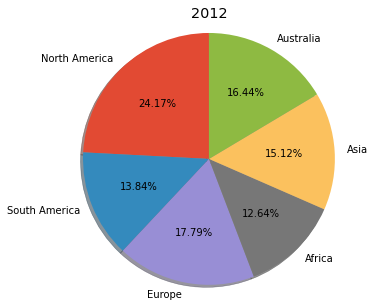

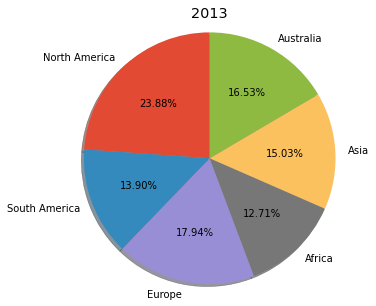

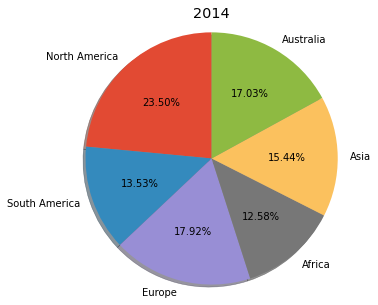

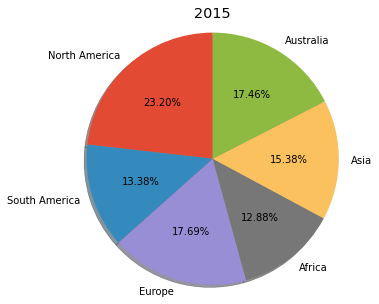

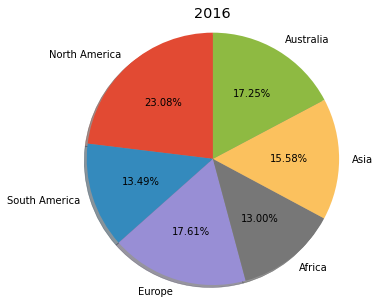

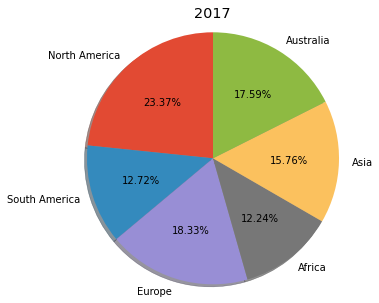

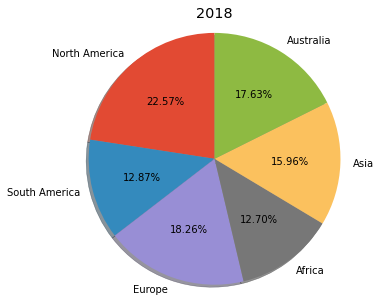

In [23]:
# Average university score vs continent

plt.rcParams['figure.figsize'] = 5,5
for year in range(min_year,max_year+1):
  labels = continents
  sizes = [continent_info[year]['scores'][continent]/continent_info[year]['num_univs'][continent] for continent in continents]

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title(str(year))
plt.show()